# Outlier Detection using scikit-learn
An outlier is a data point that is distant from other similar points. They may be due to variability in the measurement or may indicate experimental errors. If possible, outliers should be excluded from the data set. However, detecting that anomalous instances might be very difficult, and is not always possible.
<img src="outlier_detection/outlier.jpg">

When the amount of contamination is known, this example illustrates three different ways of performing Novelty and Outlier Detection:

- based on a robust estimator of covariance, which is assuming that the data are Gaussian distributed and performs better than the One-Class SVM in that case.
- using the One-Class SVM and its ability to capture the shape of the data set, hence performing better when the data is strongly non-Gaussian, i.e. with two well-separated clusters;
- using the Isolation Forest algorithm, which is based on random forests and hence more adapted to large-dimensional settings, even if it performs quite well in the examples below.
- using the Local Outlier Factor to measure the local deviation of a given data point with respect to its neighbors by comparing their local density.

In [62]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.font_manager
from pylab import savefig
from IPython.core.display import HTML

%matplotlib inline
HTML("""
<style>
.MathJax {
font-size: 1.8em;
}
</style>
""")

In [63]:
from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

def outlier_detection (X, clf_name, outlier_fraction = 0.25, random_seed = 42):
    """ 
    Define outlier detection tool to be used
    """
    rng = np.random.RandomState(random_seed)
    classifiers = {
        "One-Class SVM": svm.OneClassSVM(nu=0.95 * outliers_fraction + 0.05, kernel="rbf", gamma=0.1),
        "Robust covariance": EllipticEnvelope(contamination=outliers_fraction),
        "Isolation Forest": IsolationForest(max_samples=X.shape[0], contamination=outliers_fraction, random_state=rng),
        "Local Outlier Factor": LocalOutlierFactor(n_neighbors=35, contamination=outliers_fraction)}

    # Fit the model
    clf = classifiers[clf_name]

    # fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_pred = clf.negative_outlier_factor_
    else:
        clf.fit(X)
        scores_pred = clf.decision_function(X)
        y_pred = clf.predict(X)
        
    return y_pred, scores_pred, clf

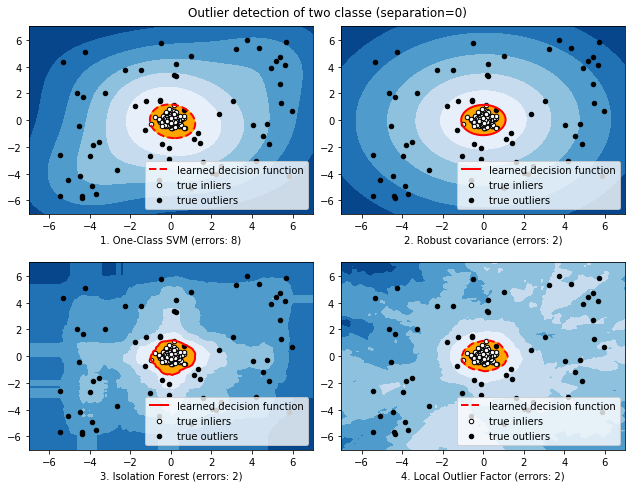

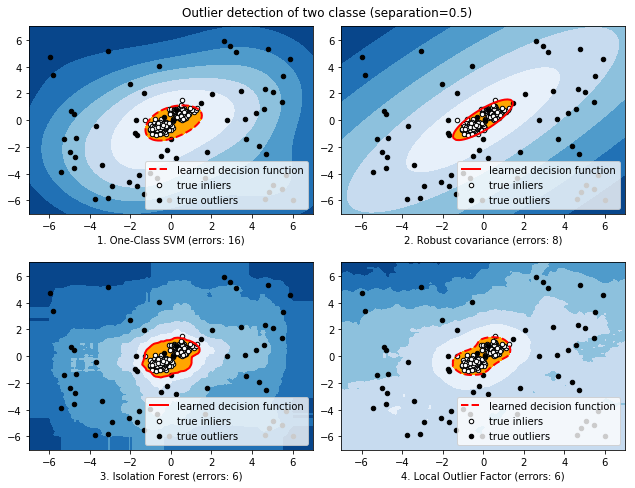

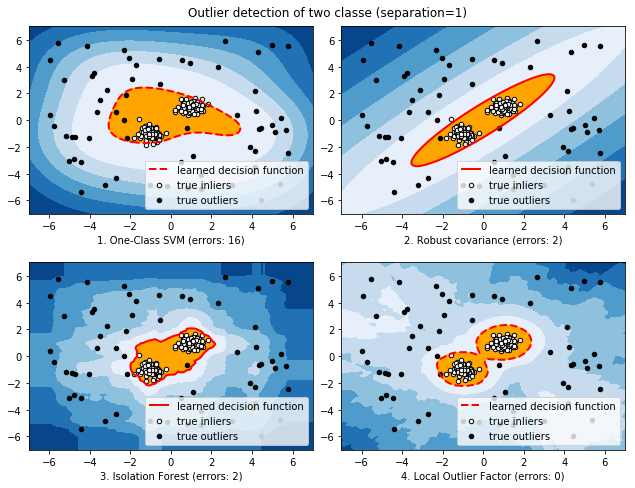

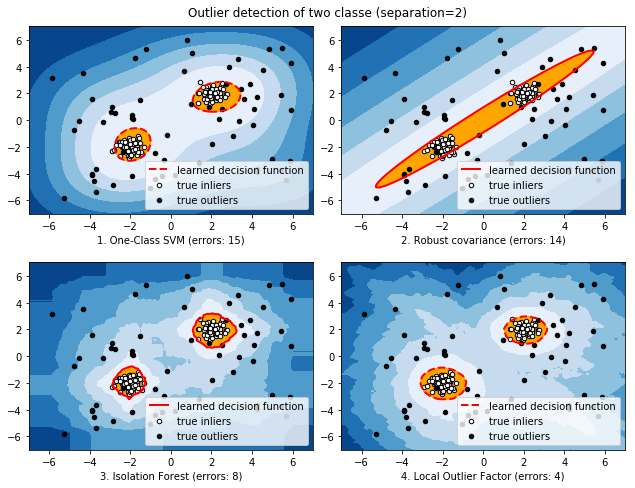

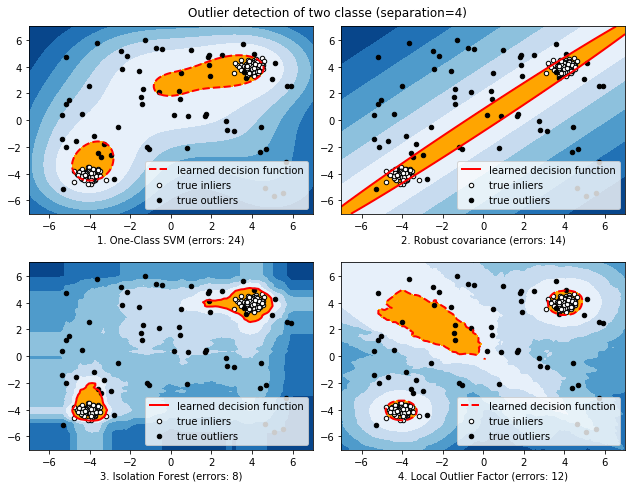

In [64]:
# unit1 test1 using visual analytics
# http://scikit-learn.org/stable/auto_examples/covariance/plot_outlier_detection.html#sphx-glr-auto-examples-covariance-plot-outlier-detection-py
np.random.seed(42)

# Example settings
n_samples = 250
outliers_fraction = 0.25
clusters_separation = [0, 0.5, 1, 2, 4]

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 100), np.linspace(-7, 7, 100))
n_inliers = int((1. - outliers_fraction) * n_samples)
n_outliers = n_samples- n_inliers
ground_truth = np.ones(n_samples, dtype=int)
ground_truth[-n_outliers:] = -1

for offset in clusters_separation:
    # Data generation
    X1 = 0.3 * np.random.randn(n_inliers // 2, 2) - offset
    X2 = 0.3 * np.random.randn(n_inliers - X1.shape[0], 2) + offset
    X = np.r_[X1, X2]
    
    # Add outliers
    X = np.r_[X, np.random.uniform(low=-6, high=6, size=(n_outliers, 2))]
    
    # Fit the model
    plt.figure(figsize=(9, 7))
    for i, clf_name in enumerate(["One-Class SVM","Robust covariance","Isolation Forest","Local Outlier Factor"]):
        
        # fit the data and tag outlier
        y_pred, scores_pred, clf = outlier_detection (X, clf_name, outliers_fraction, random_seed = 42)

        threshold = stats.scoreatpercentile(scores_pred, 100 * outliers_fraction)
        n_errors = (y_pred != ground_truth).sum()
        

        # plot the levels lines and the points
        if clf_name == "Local Outlier Factor":
            # decision_function is private for LOF
            Z = clf._decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        subplot = plt.subplot(2, 2, i + 1)
        subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                         cmap=plt.cm.Blues_r)
        a = subplot.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, colors='red')
        subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                         colors='orange')
        b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white',
                            s=20, edgecolor='k')
        c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black',
                            s=20, edgecolor='k')
        subplot.axis('tight')
        subplot.legend(
            [a.collections[0], b, c],
            ['learned decision function', 'true inliers', 'true outliers'],
            prop=matplotlib.font_manager.FontProperties(size=10),
            loc='lower right')
        subplot.set_xlabel("%d. %s (errors: %d)" % (i + 1, clf_name, n_errors))
        subplot.set_xlim((-7, 7))
        subplot.set_ylim((-7, 7))
    plt.subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.1, 0.26)
    plt.suptitle("Outlier detection of two classe (separation={})".format(offset))

plt.show()

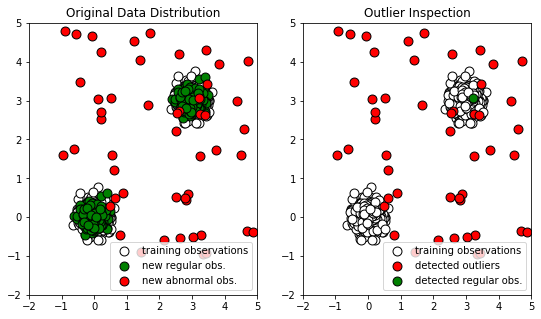

Accuracy (detecting inliers): 0.74
Accuracy (detectng outliers): 0.98


In [65]:
# Unit test2 using accuracy on training and test
# https://towardsdatascience.com/outlier-detection-with-isolation-forest-3d190448d45e

# Generating training data 
rng = np.random.RandomState(42)
X_train = 0.2 * rng.randn(1000, 2)
X_train = np.r_[X_train + 3, X_train]
X_train = pd.DataFrame(X_train, columns = ['x1', 'x2'])

# Generating new, 'normal' observation
X_test = 0.2 * rng.randn(200, 2)
X_test = np.r_[X_test + 3, X_test]
X_test = pd.DataFrame(X_test, columns = ['x1', 'x2'])

# Generating outliers
X_outliers = rng.uniform(low=-1, high=5, size=(50, 2))
X_outliers = pd.DataFrame(X_outliers, columns = ['x1', 'x2'])

# Plotting generated data ----
plt.figure(figsize=(9, 5))
subplot = plt.subplot(1, 2, 1)
subplot.set_title("Original Data Distribution")
p1 = subplot.scatter(X_train.x1, X_train.x2, c='white',
                 s=20*4, edgecolor='k')
p2 = subplot.scatter(X_test.x1, X_test.x2, c='green',
                 s=20*4, edgecolor='k')
p3 = subplot.scatter(X_outliers.x1, X_outliers.x2, c='red',
                s=20*4, edgecolor='k')
subplot.axis('tight')
subplot.set_xlim((-2, 5))
subplot.set_ylim((-2, 5))
subplot.legend([p1, p2, p3],
           ["training observations",
            "new regular obs.", "new abnormal obs."],
           loc="lower right")


# training the model
y_pred_train, _, clf = outlier_detection (X_train, 'Isolation Forest', outlier_fraction = 0.25, random_seed = 42)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

#Inspecting the results
X_outliers = X_outliers.assign(y = y_pred_outliers)
subplot = plt.subplot(1, 2, 2)
subplot.set_title("Outlier Inspection")
p1 = subplot.scatter(X_train.x1, X_train.x2, c='white',
                 s=20*4, edgecolor='k')
p2 = subplot.scatter(X_outliers.loc[X_outliers.y == -1, ['x1']], 
                 X_outliers.loc[X_outliers.y == -1, ['x2']], 
                 c='red', s=20*4, edgecolor='k')
p3 = subplot.scatter(X_outliers.loc[X_outliers.y == 1, ['x1']], 
                 X_outliers.loc[X_outliers.y == 1, ['x2']], 
                 c='green', s=20*4, edgecolor='k')
subplot.axis('tight')
subplot.set_xlim((-2, 5))
subplot.set_ylim((-2, 5))
subplot.legend([p1, p2, p3],
           ["training observations",
            "detected outliers", 
            "detected regular obs."],
           loc="lower right")

plt.show()

print("Accuracy (detecting inliers):", list(y_pred_test).count(1)/y_pred_test.shape[0])
print("Accuracy (detectng outliers):", list(y_pred_outliers).count(-1)/y_pred_outliers.shape[0])

In [66]:
#Unit test3 for sequential data
# https://www.neuraldesigner.com/blog/3_methods_to_deal_with_outliers

# Outlier Detection Methods

## 1- Isolation Forests
During a recent project I was working on a clustering problem with data collected from users of a mobile app. The goal was to classify the users in terms of their behaviour, potentially with the use of K-means clustering. However, after inspecting the data it turned out that some users represented abnormal behaviour  they were outliers.

A lot of machine learning algorithms suffer in terms of their performance when outliers are not taken care of. In order to avoid this kind of problems you could, for example, drop them from your sample, cap the values at some reasonable point (based on domain knowledge) or transform the data. However, in this article I would like to focus on identifying them and leave the possible solutions for another time.

As in my case I took a lot of features into consideration, I ideally wanted to have an algorithm that would identify the outliers in a multidimensional space. That is when I came across Isolation Forest, a method which in principle is similar to the well-known and popular Random Forest. In this article I will focus on the Isolation Forest, without describing in detail the ideas behind decision trees and ensembles, as there is already a plethora of good sources available.

The main idea, which is different from other popular outlier detection methods, is that Isolation Forest explicitly identifies anomalies instead of profiling normal data points. Isolation Forest, like any tree ensemble method, is built on the basis of decision trees. In these trees, partitions are created by first randomly selecting a feature and then selecting a random split value between the minimum and maximum value of the selected feature.

In principle, outliers are less frequent than regular observations and are different from them in terms of values (they lie further away from the regular observations in the feature space). That is why by using such random partitioning they should be identified closer to the root of the tree (shorter average path length, i.e., the number of edges an observation must pass in the tree going from the root to the terminal node), with fewer splits necessary.

The idea of identifying a normal vs. abnormal observation can be observed in Figure 1 from [1]. A normal point (on the left) requires more partitions to be identified than an abnormal point (right).

<div align="centre">
    <img src="outlier_detection/isolation_forest_explain.png">
    <span align="centre"> Figure 1 Identifying normal vs. abnormal observations</span>
</div>
As with other outlier detection methods, an anomaly score is required for decision making. In case of Isolation Forest it is defined as:

$$s(x,n) = 2^{-\frac{E(h(x))}{c(n)}}$$

where $h(x)$ is the path length of observation $x$, $c(n)$ is the average path length of unsuccessful search in a Binary Search Tree and n is the number of external nodes. More on the anomaly score and its components can be read in [1].

Each observation is given an anomaly score and the following decision can be made on its basis:

- Score close to 1 indicates anomalies
- Score much smaller than 0.5 indicates normal observations
- If all scores are close to 0.5 than the entire sample does not seem to have clearly distinct anomalies

Summing up:

- Isolation Forest is an outlier detection technique that identifies anomalies instead of normal observations
- Similarly to Random Forest it is built on an ensemble of binary (isolation) trees
- It can be scaled up to handle large, high-dimensional datasets

[1] Liu, F. T., Ting, K. M., & Zhou, Z. H. (2008, December). Isolation forest. In *Data Mining, 2008. ICDM’08. Eighth IEEE International Conference on* (pp. 413422). IEEE.


## 2- 